In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset")

print("Path to dataset files:", path)


100%|█████████████████████████████████████████████████████████████████████████████| 22.5G/22.5G [40:09<00:00, 10.0MB/s]

Extracting files...


Path to dataset files: C:\Users\Tanish Garg\.cache\kagglehub\datasets\sanikatiwarekar\deep-fake-detection-dfd-entire-original-dataset\versions\1


In [3]:
pip install scikit-optimize



   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   ---------------------------------------- 2/2 [scikit-optimize]

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install opencv-python


   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 882.6 kB/s eta 0:00:45
    --------------------------------------- 0.5/39.5 MB 882.6 kB/s eta 0:00:45
    --------------------------------------- 0.5/39.5 MB 882.6 kB/s eta 0:00:45
    --------------------------------------- 0.8/39.5 MB 524.3 kB/s eta 0:01:14
    --------------------------------------- 0.8/39.5 MB 524.3 kB/s eta 0:01:14
    --------------------------------------- 0.8/39.5 MB 524.3 kB/s eta 0:01:14
    --------------------------------------- 0.8/39.5 MB 524.3 kB/s eta 0:01:14
    --------------------------------------- 0.8/39.5 MB 524.3 kB/s eta 0:01:14
    --------------------------------------- 0.8/39.5 MB 524.3 kB/s eta 0:01:14
    -----

In [1]:
import os
import pathlib
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from torchvision.models import VGG16_Weights
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from skopt import gp_minimize
from skopt.space import Real
from torch import nn
from torch.optim import Adam
import cv2
import shutil
import numpy as np
from PIL import Image
import random
import json

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
dataset_dir = pathlib.Path(r'C:\Users\Tanish Garg\.cache\kagglehub\datasets\sanikatiwarekar\deep-fake-detection-dfd-entire-original-dataset')
original_videos = dataset_dir / "DFD_original sequences"
manipulated_videos = dataset_dir / "DFD_manipulated_sequences"

In [4]:
num_original_videos = len(list(original_videos.glob("*.mp4"))) 
num_manipulated_videos = len(list(manipulated_videos.glob("*.mp4")))
print(f"Original videos: {num_original_videos}")
print(f"Manipulated videos: {num_manipulated_videos}")

Original videos: 363
Manipulated videos: 3068


In [5]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/cross_validation")

Helper functions

In [6]:
from PIL import Image
import numpy as np

def __getitem__(self, idx):
    label = self.labels[idx]
    # Mock image data as a NumPy array
    image = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)  # Simulating an image
    
    if self.transform:
        image = self.transform(Image.fromarray(image))  # Convert to PIL Image

    return image, label

In [7]:
transform = transforms.Compose([
    # transforms.Resize((135, 240)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None, frames_per_video=16):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.frames_per_video = frames_per_video

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        # Load multiple frames from the video
        frames = self.load_video_frames(video_path, self.frames_per_video)

        # Apply transformations to frames
        if self.transform:
            frames = [self.transform(Image.fromarray(frame)) for frame in frames]
        
        # Stack frames to form a sequence
        frames = torch.stack(frames)
        return frames, label


    def load_video_frames(self, video_path, num_frames):
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f"Error opening video: {video_path}")
            return []  # Return empty if the video cannot be opened

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count - 1, num_frames, dtype=np.int32)
    
        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                break
        cap.release()
    
        # If we don't have enough frames, repeat the last frame
        if len(frames) < num_frames:
            frames += [frames[-1]] * (num_frames - len(frames))
    
        return frames

In [9]:
def balance_dataset(original_videos_dir, manipulated_videos_dir, output_dir, target_count=20):

    # Create output directories
    balanced_original_dir = output_dir / "original"
    balanced_manipulated_dir = output_dir / "manipulated"
    balanced_original_dir.mkdir(parents=True, exist_ok=True)
    balanced_manipulated_dir.mkdir(parents=True, exist_ok=True)

    # Sample videos
    original_videos = list(original_videos_dir.glob("*.mp4"))
    manipulated_videos = list(manipulated_videos_dir.glob("*.mp4"))

    sampled_original = random.sample(original_videos, target_count)
    sampled_manipulated = random.sample(manipulated_videos, target_count)

    # Copy sampled videos to output directories
    for file in sampled_original:
        shutil.copy(file, balanced_original_dir / file.name)

    for file in sampled_manipulated:
        shutil.copy(file, balanced_manipulated_dir / file.name)

    print(f"Balanced dataset created with {target_count} videos in each class.")
    return (sampled_original, [0] * len(sampled_original)), (sampled_manipulated, [1] * len(sampled_manipulated))


In [10]:
num_original_videos = len(list(original_videos.glob("*.mp4")))  # Adjust file extension if needed
num_manipulated_videos = len(list(manipulated_videos.glob("*.mp4")))

print(f"Original videos: {num_original_videos}")
print(f"Manipulated videos: {num_manipulated_videos}")

Original videos: 363
Manipulated videos: 3068


In [11]:
# Paths
balanced_dir = pathlib.Path('./balanced_dataset')
balanced_samples = balance_dataset(original_videos, manipulated_videos, balanced_dir)

Balanced dataset created with 20 videos in each class.


In [12]:
balanced_dir = pathlib.Path('./balanced_dataset')
balanced_original = balanced_dir / "original"
balanced_manipulated = balanced_dir / "manipulated"

# Ensure the output directories exist
balanced_original.mkdir(parents=True, exist_ok=True)
balanced_manipulated.mkdir(parents=True, exist_ok=True)

In [13]:
# Update dataset paths to point to the new subset
balanced_video_paths = []
balanced_labels = []

for video_path in balanced_original.glob("*.mp4"):
    balanced_video_paths.append(video_path)
    balanced_labels.append(0)  # Label 0 for original

for video_path in balanced_manipulated.glob("*.mp4"):
    balanced_video_paths.append(video_path)
    balanced_labels.append(1)  # Label 1 for manipulated

In [14]:
print(f"Balanced dataset created with 75 videos in each class.")
print(f"Original videos saved to: {balanced_original}")
print(f"Manipulated videos saved to: {balanced_manipulated}")

Balanced dataset created with 75 videos in each class.
Original videos saved to: balanced_dataset\original
Manipulated videos saved to: balanced_dataset\manipulated


In [15]:
balanced_original_dir = pathlib.Path('./balanced_dataset/original')
balanced_manipulated_dir = pathlib.Path('./balanced_dataset/manipulated')

original_count = len(list(balanced_original_dir.glob("*.mp4")))
manipulated_count = len(list(balanced_manipulated_dir.glob("*.mp4")))
print(f"Number of videos in 'original': {original_count}")
print(f"Number of videos in 'manipulated': {manipulated_count}")

Number of videos in 'original': 20
Number of videos in 'manipulated': 20


In [16]:
balanced_dataset = VideoDataset(balanced_video_paths,balanced_labels, transform=transform)

In [17]:
balanced_dataset[1][0].shape

torch.Size([16, 3, 224, 224])

In [18]:
# Validation
# fixing KFold -- going to normal validation 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_splits = [(train_idx, val_idx) for train_idx, val_idx in kf.split(balanced_video_paths)][:1]
# getting just the first split 

Training

In [19]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import VGG16_Weights

class VGG16LSTM(nn.Module):
    def __init__(self, num_classes=2, lstm_hidden_size=256, lstm_num_layers=1, freeze_feature_extractor=True):
        super(VGG16LSTM, self).__init__()
        
        # Load pretrained VGG16 features
        self.feature_extractor = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # VGG16 uses a (7x7) pool by default
        self.fc_features = nn.Linear(512 * 7 * 7, 1024)

        # Optionally freeze the feature extractor
        if freeze_feature_extractor:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=1024, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        
        # Reshape input for the feature extractor
        x = x.view(batch_size * seq_len, c, h, w)
        features = self.feature_extractor(x)
        
        # Pool and flatten
        features = self.avgpool(features)
        features = torch.flatten(features, start_dim=1)
        features = self.fc_features(features)
        
        # Reshape for LSTM input
        features = features.view(batch_size, seq_len, -1)
        
        # Flatten LSTM weights (needed for CuDNN)
        self.lstm.flatten_parameters()
        
        # Forward through LSTM
        lstm_out, _ = self.lstm(features)
        
        # Take the last time step's output
        final_output = lstm_out[:, -1, :]
        
        # Forward through the classifier
        output = self.fc(final_output)
        return output

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras

#Pretty simplistic classifier, just to get it up and running, we can fine tune stuff after the check in
class VideoModel(nn.Module):
    def __init__(self, num_classes=2):
        super(VideoModel, self).__init__()
        #hard coding everything for now, should define variables for generalization later...
        
        #the 3d convolution model, simplistic for now, just getting the data in a smaller and more succinct format
        self.conv_model = nn.Sequential(
            nn.LazyConv3d(out_channels=32, kernel_size=(3, 16, 16), stride = (3, 16, 16), padding="valid"),
            nn.ReLU(), 
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            # adding dropout to try to increase accuracy after pooling 
            nn.Dropout(0.25), 
            # keras.layers.Conv3D(filters=64, kernel_size=(3, 16, 16), strides = (3, 16, 16), activation="relu", padding="valid"),
            # keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),

            # adding more convolutions 
            nn.LazyConv3d(out_channels=64, kernel_size=(3,3,3), stride=(1,1,1), padding="same"), 
            nn.ReLU(), 
            nn.LazyBatchNorm3d(), 
            # Changed pool size to avoid dimension error
            nn.MaxPool3d(kernel_size=(1,2,2)), 
            nn.Dropout(0.25), 

            nn.LazyConv3d(out_channels=128, kernel_size=(3,3,3), stride=(1,1,1), 
            padding="same"), 
            nn.ReLU(), 
            nn.LazyBatchNorm3d(), 
            # Removed problematic pooling layer that caused the dimension error
            # keras.layers.MaxPooling3D(pool_size=(2,2,2)), 
            nn.Dropout(0.3), 

            # tf.reshape(-1, 128) #just need to reshape to the embedding dimension we want for attention, using 128 here...
            # Updated reshape to match the actual output dimensions after convolutions
            # nn.Flatten((-1, 128)), 
            #probably want to go back and confirm this is what we want to do / handle the reshapes better
        )
        
        #this one is to perform attention on the layers post convolution
        # self.attention = keras.Sequential([
        #     keras.layers.LayerNormalization(),
        #     keras.layers.MultiHeadAttention(num_heads = 4, key_dim=64)
        # ])
        self.attention = nn.MultiheadAttention(num_heads=8, embed_dim=128, batch_first = True) #got an error here so switched to built in multiheaded attention
        #after attention, we should take residual connections and normalize again, dense layer to help with the classification
        #we can decide if we wanna stack transformers??? Probably better to get a running model in a timely fashion for now
        self.post_attention = nn.Sequential(
            # make it such that the entire sequence has mean = 0 and standard deviation = 1 
            nn.LayerNorm(128),
            # previous: keras.layers.Dense(120, activation="relu"),
            nn.LazyLinear(128),
            nn.ReLU(), 
            nn.Dropout(0.4), 
            # adding more layers here 
            nn.LazyLinear(128),
            nn.ReLU(), 
            # adding dropout after the dense layers 
            nn.Dropout(0.5)
        )
        #this next sequential is for classification itself
        self.classification = nn.Sequential(
         #was told this is often used when there's a temporal dimension, just averages across time to collapse vectors...
            # adding more layers here 
            nn.LazyLinear(128), 
            nn.ReLU(), 
            nn.Dropout(0.5), 
            nn.LazyLinear(64), 
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.LazyLinear(2), 
            nn.Softmax(dim=-1) 
        )
    
    def forward(self, videos):
        # Adding training flag to all components that need it
        # flipping time and channel axes 
        conv = self.conv_model(videos.swapaxes(1,2))
        # print(conv.shape)
        conv = conv.swapaxes(1,-1).flatten(1,3)
        # flatten the 1,2,3 dimensions 
        att, weights = self.attention(conv, conv, conv)
        skip = att + conv
       #  print(skip.shape) .. output before classification 
        post_att = self.post_attention(skip)
        post_att = post_att.mean(dim=1) 
        # 1 x 128, where is the batch axis and 128 is embedding (?) 
        return self.classification(post_att) 

model = VideoModel()
model(torch.randn(1, 16, 3,224,224))
# batch, time, channels, height, width 

# printing probability that this random set of inputs is an input

tensor([[0.4804, 0.5196]], grad_fn=<SoftmaxBackward0>)

In [21]:
from tqdm import tqdm  # Progress bar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model, loss function, and optimizer
model = VideoModel(num_classes=2).to(device)
model(torch.randn(1, 16, 3,224,224).to(device))
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

In [22]:
# Train and validate
def train_and_validate(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()  # Sezt model to training mode
        running_loss = 0.0

        # Training loop with progress bar
        print(f"Epoch {epoch + 1}/{epochs}")
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

        for batch_idx, (videos, labels) in train_progress:
            videos, labels = videos.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_progress.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1} Training Loss: {running_loss / len(train_loader):.4f}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validating")
            for batch_idx, (videos, labels) in val_progress:
                videos, labels = videos.to(device), labels.to(device)

                # Forward pass
                outputs = model(videos)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy calculation
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        print(f"Epoch {epoch + 1} Validation Loss: {val_loss / len(val_loader):.4f}")
        print(f"Epoch {epoch + 1} Validation Accuracy: {100 * correct / total:.2f}%\n")

In [23]:
from sklearn.metrics import  precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(model, val_loader):
    y_true = []
    y_pred = []
    tp=0
    tn=0
    fp=0
    fn=0


    # Collect predictions and true labels
    model.eval()
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            tp += ((preds == 1) & (labels == 1)).sum().item()
            tn += ((preds == 0) & (labels == 0)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()


    # Compute metrics
    
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    cm= np.array([[tp, fn], [fp, tn]])

    return cm,acc, precision, recall, f1

In [24]:
metrics = {
    "accuracy": [],
    "preision": [],
    "recall": [],
    "f1_score": []
}

In [25]:
# Dataset split
train_idx = list(range(0, 120))  # Adjust according to your dataset
val_idx = list(range(120, 150))
train_dataset = Subset(balanced_dataset, train_idx)
val_dataset = Subset(balanced_dataset, val_idx)
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [26]:
# Check if these directories contain video files
print(len(list(original_videos.glob("*.mp4"))))
print(len(list(manipulated_videos.glob("*.mp4"))))
print(len(train_dataset))
print(len(val_dataset))

363
3068
120
30


In [27]:
def plot_confusion_matrix(cm, labels=["Positive", "Negative"]):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Positive", "Negative"], 
                yticklabels=["Positive", "Negative"])
    plt.ylabel("Predicted Values")
    plt.xlabel("Actual Values")
    plt.title("Confusion Matrix")
    plt.show()


Fold 1:
Epoch 1/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it, loss=0.701]


Epoch 1 Training Loss: 0.6974


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.68s/it]


Epoch 1 Validation Loss: 0.6820
Epoch 1 Validation Accuracy: 75.00%

Epoch 2/10


Training: 100%|███████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.81s/it, loss=0.69]


Epoch 2 Training Loss: 0.6945


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.09s/it]


Epoch 2 Validation Loss: 0.6845
Epoch 2 Validation Accuracy: 75.00%

Epoch 3/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.99s/it, loss=0.699]


Epoch 3 Training Loss: 0.6929


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.87s/it]


Epoch 3 Validation Loss: 0.6863
Epoch 3 Validation Accuracy: 100.00%

Epoch 4/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.10s/it, loss=0.683]


Epoch 4 Training Loss: 0.6893


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.46s/it]


Epoch 4 Validation Loss: 0.6894
Epoch 4 Validation Accuracy: 25.00%

Epoch 5/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.14s/it, loss=0.709]


Epoch 5 Training Loss: 0.6826


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.01s/it]


Epoch 5 Validation Loss: 0.6866
Epoch 5 Validation Accuracy: 25.00%

Epoch 6/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:02<00:00, 24.51s/it, loss=0.689]


Epoch 6 Training Loss: 0.6920


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.47s/it]


Epoch 6 Validation Loss: 0.6874
Epoch 6 Validation Accuracy: 25.00%

Epoch 7/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.31s/it, loss=0.622]


Epoch 7 Training Loss: 0.6697


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


Epoch 7 Validation Loss: 0.6715
Epoch 7 Validation Accuracy: 25.00%

Epoch 8/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.44s/it, loss=0.669]


Epoch 8 Training Loss: 0.6866


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.15s/it]


Epoch 8 Validation Loss: 0.6484
Epoch 8 Validation Accuracy: 25.00%

Epoch 9/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [03:56<00:00, 47.27s/it, loss=0.582]


Epoch 9 Training Loss: 0.6685


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.97s/it]


Epoch 9 Validation Loss: 0.6744
Epoch 9 Validation Accuracy: 50.00%

Epoch 10/10


Training: 100%|██████████████████████████████████████████████████████████████| 5/5 [02:59<00:00, 35.87s/it, loss=0.635]


Epoch 10 Training Loss: 0.6583


Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.78s/it]


Epoch 10 Validation Loss: 0.6102
Epoch 10 Validation Accuracy: 100.00%



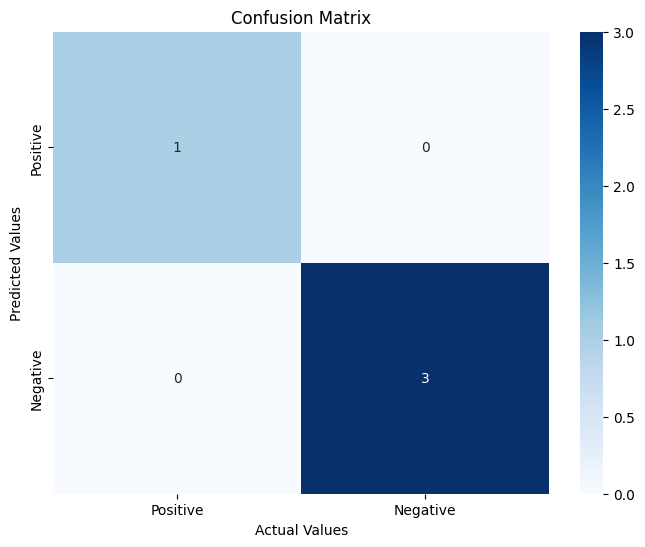

Final Fold 1 Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000



In [28]:
# Cross-validation loop
for fold_idx, (train_idx, val_idx) in enumerate(fold_splits):
    print(f"\nFold {fold_idx + 1}:")

    # Prepare DataLoaders for the fold
    train_dataset = Subset(balanced_dataset, train_idx)
    val_dataset = Subset(balanced_dataset, val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

    # Initialize model and optimizer for each fold
    model = VideoModel(num_classes=2).to(device)
    model(torch.randn(1, 16, 3,224,224).to(device))
    
    # model.lstm.flatten_parameters()
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train and validate for the fold
    train_and_validate(model, train_loader, val_loader, epochs=10)

    
    # Evaluate final metrics for the fold
    cm, acc, precision, recall, f1 = evaluate_model(model, val_loader)
    plot_confusion_matrix(cm)
    
    print(f"Final Fold {fold_idx + 1} Metrics - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")
    # After fold evaluation
    writer.add_scalar(f"Fold_{fold_idx+1}/Accuracy", acc, fold_idx + 1)
    writer.add_scalar(f"Fold_{fold_idx+1}/Precision", precision, fold_idx + 1)
    writer.add_scalar(f"Fold_{fold_idx+1}/Recall", recall, fold_idx + 1)
    writer.add_scalar(f"Fold_{fold_idx+1}/F1_Score", f1, fold_idx + 1)
    writer.add_figure(f"Fold_{fold_idx+1}/Confusion_Matrix", plt.gcf(), fold_idx + 1)

In [31]:
torch.save(model.state_dict(), r'C:\Users\Tanish Garg\OneDrive\Desktop\personal project\deep fake detection\vgg16_model.pth')


In [32]:
writer.close()